In [1]:
import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
import random

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.ops.indexing import Vindex

pyro.enable_validation(True)



In [5]:
def generate_data(group) :
    big_val = dist.Beta(10, 1)
    small_val = dist.Beta(1, 10)
    # small_val = dist.Normal(0, 0.1)
    # big_val = dist.Normal(5, 0.1)
    if group == 'within' :
        return torch.tensor([small_val.sample(), big_val.sample(), big_val.sample(), small_val.sample()])
    elif group == 'across' :
        return torch.tensor([big_val.sample(), small_val.sample(), small_val.sample(), big_val.sample()])

random.seed(680814)
data = torch.stack([generate_data('across') for i in range(100)] +
                   [generate_data('within') for i in range(100)],
                   dim=0)
#print(data)
print(data.shape)



torch.Size([200, 4])


In [31]:
K = 2  # Fixed number of components.

# Q: what was the actual fix here? it seems like it;s not about switching from [assignment,:] to [assignment]
# is it the to_event(1), or is it about getting the indexing done/ declaring the beta distribution with advanced indexing outside of the pyro.sample statement?

# Seems like taking the to_event thing out WRECKS it

@config_enumerate()
def model(data):
    # Background probability of different groups (assume equally likely)
    weights = torch.tensor([0.5, 0.5])
#    scale = pyro.sample('scale', dist.LogNormal(torch.zeros(4), 2. * torch.ones(4)).to_event(1))
    with pyro.plate('components', K):
        # concentration parameters
        alphas = pyro.sample('alpha', dist.Gamma(2 * torch.ones(4), 1/3 * torch.ones(4)).to_event(1))
        betas = pyro.sample('beta', dist.Gamma(2 * torch.ones(4), 1/3 * torch.ones(4)).to_event(1))

    with pyro.plate('data', data.shape[0]):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        d = dist.Beta(alphas[assignment], betas[assignment])
        #d = dist.Beta(alphas[assignment,:], betas[assignment,:]) # this works just as well
        pyro.sample('obs', d.to_event(1), obs=data)
        

In [57]:
# a version where the weight is also inferred

@config_enumerate()
def model(data):
    # Background probability of different groups (assume equally likely)
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
#    scale = pyro.sample('scale', dist.LogNormal(torch.zeros(4), 2. * torch.ones(4)).to_event(1))
    with pyro.plate('components', K):
        # concentration parameters
        alphas = pyro.sample('alpha', dist.Gamma(2 * torch.ones(4), 1/3 * torch.ones(4)).to_event(1))
        betas = pyro.sample('beta', dist.Gamma(2 * torch.ones(4), 1/3 * torch.ones(4)).to_event(1))

    with pyro.plate('data', data.shape[0]):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        d = dist.Beta(alphas[assignment], betas[assignment])
        print(d.batch_shape, d.event_shape)
        print(d.to_event(1).batch_shape, d.to_event(1).event_shape)
        #d = dist.Beta(alphas[assignment,:], betas[assignment,:]) # this works just as well
        pyro.sample('obs', d.to_event(1), obs=data)
      

In [58]:
model(data)

torch.Size([200, 4]) torch.Size([])
torch.Size([200]) torch.Size([4])


In [51]:
optim = pyro.optim.Adam({'lr': 0.0005, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

def initialize(seed):           
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['weights','alpha', 'beta']))
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, data)

loss, seed = min((initialize(seed), seed) for seed in range(100))
#initialize(100)
print('seed = {}, initial_loss = {}'.format(seed, loss))


seed = 95, initial_loss = 3147.656005859375


In [ ]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(10000):
    loss = svi.step(data)
    print(loss)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

map_estimates = global_guide(data)
alphas = map_estimates['alpha']
betas = map_estimates['beta']
print('alphas = {}'.format(alphas.data.numpy()))
print('betas = {}'.format(betas.data.numpy()))
weights = map_estimates['weights']
print(weights)

In [61]:
map_estimates

{'weights': tensor([0.5000, 0.5000], grad_fn=<ExpandBackward>),
 'alpha': tensor([[ 0.8944,  9.6379, 11.1209,  0.8509],
         [ 8.2513,  0.7985,  0.9122, 10.3753]], grad_fn=<ExpandBackward>),
 'beta': tensor([[7.5721, 1.0154, 1.0090, 7.0486],
         [0.8772, 7.8338, 8.9108, 1.0284]], grad_fn=<ExpandBackward>)}

In [39]:
# i think(?) this is needed to set random seed for pyro fns
pyro.set_rng_seed(19931007)

from pyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=5000, warmup_steps=1000)
mcmc.run(data)

#hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|███████████████████████████████████████| 6000/6000 [13:01,  7.68it/s, step size=3.51e-01, acc. prob=0.899]


In [33]:
posterior_samples = mcmc.get_samples()
X, Y = posterior_samples["alpha"][:,:,1].t() # get the alpha samples for the top left corner for both groups

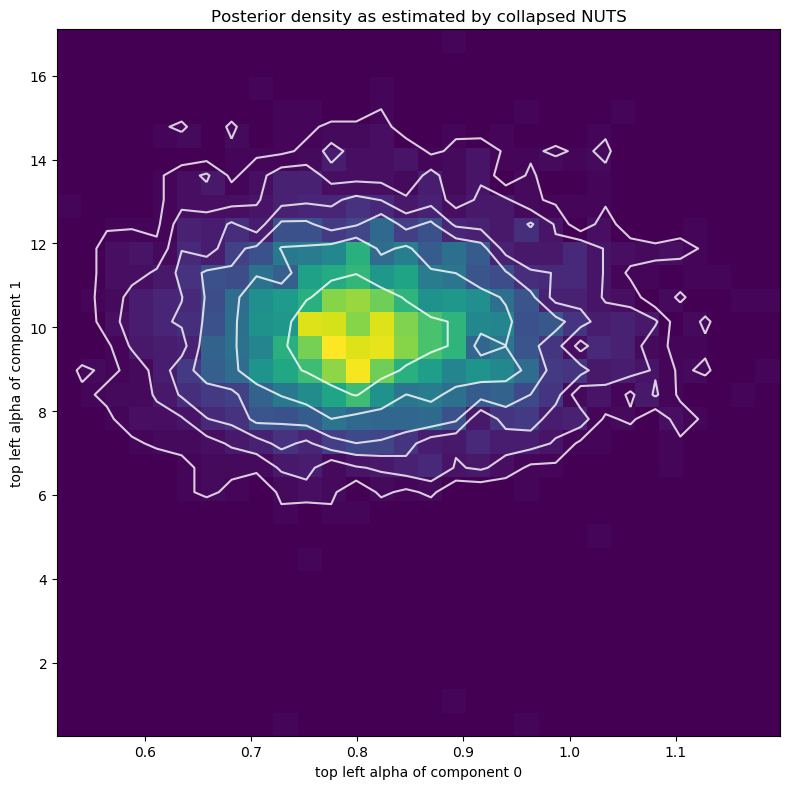

In [49]:
pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
h, xs, ys, image = pyplot.hist2d(X.numpy(), Y.numpy(), bins=[30, 30])
pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
               colors='white', alpha=0.8)
pyplot.title('Posterior density as estimated by collapsed NUTS')
pyplot.xlabel('top left alpha of component 0')
pyplot.ylabel('top left alpha of component 1')
pyplot.tight_layout()

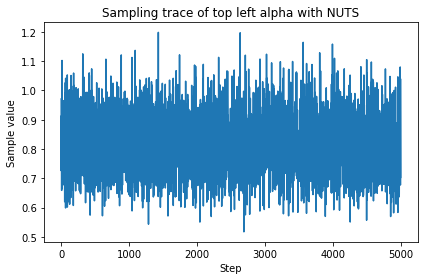

In [38]:
#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.plot(np.arange(X.numpy().size),X.numpy())
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left alpha with NUTS')
pyplot.ylabel('Sample value')
pyplot.xlabel('Step')
pyplot.tight_layout()

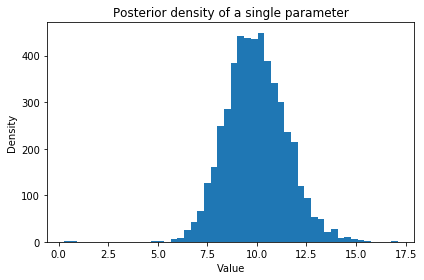

In [60]:
#pyplot.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
pyplot.hist(Y.numpy(),bins=50)
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Posterior density of a single parameter')
pyplot.ylabel('Density')
pyplot.xlabel('Value')
pyplot.tight_layout()

In [40]:
# serving SVI for prediction - on original data
guide_trace = poutine.trace(global_guide).get_trace(data)  # record the globals
trained_model = poutine.replay(model, trace=guide_trace)  # replay the globals

def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                    first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    return trace.nodes["assignment"]["value"]

classify_original = classifier(data)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0])


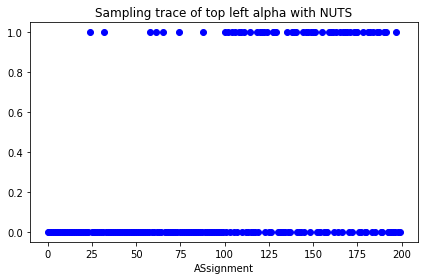

In [43]:
pyplot.plot(np.arange(classify_original.numpy().size),classify_original.numpy(),'bo')
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left alpha with NUTS')
pyplot.ylabel('Assignment')
pyplot.xlabel('')
pyplot.tight_layout()

In [46]:
# generate new data for classification
random.seed(650206)
new_data = torch.stack([generate_data('across') for i in range(100)] +
                   [generate_data('within') for i in range(100)],
                   dim=0)

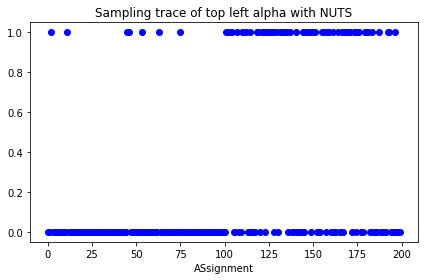

In [48]:
classify_new = classifier(new_data,0)
pyplot.plot(np.arange(classify_new.numpy().size),classify_new.numpy(),'bo')
#pyplot.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
#               colors='white', alpha=0.8)
pyplot.title('Sampling trace of top left alpha with NUTS')
pyplot.ylabel('Assignment')
pyplot.xlabel('')
pyplot.tight_layout()